In [1]:
# Import libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from pprint import pprint
plt.style.use("seaborn-v0_8")

In [2]:
file_path = "../data/HDB_data_2021_sample.xlsx"
df = pd.read_excel(file_path)

# Target and features
target_col = "resale_price"
# use log of resale_price as target
y_raw = df[target_col].values
y = np.log(y_raw)
X = df.drop(columns=[target_col])

feature_names = X.columns.tolist()

80/20 Train Test Split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

Train shape: (4800, 229)
Test shape : (1200, 229)


RMSE and hyperparameter tuning

In [4]:
def rmse(y_true, y_pred):
    # y_true and y_pred are log(prices); compute RMSE in original price units
    return np.sqrt(mean_squared_error(np.exp(y_true), np.exp(y_pred)))


def tune_and_evaluate(model, param_grid, model_name):

    """
    Tune a model with 5-fold CV, then report RMSE and R².
    model: estimator object
    param_grid: dict of hyperparameters
    model_name: string
    """

    print(f"\n{'='*60}")
    print(f"Tuning {model_name} with 5-fold CV")
    print(f"{'='*60}")



    # 5-fold shuffled CV for more stable estimates

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Use negative RMSE for tuning, but also record R² scores later

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        verbose=1,
        return_train_score=True,
    )

    grid_search.fit(X_train, y_train)
    print(f"Best params for {model_name}:")
    pprint(grid_search.best_params_)

    best_model = grid_search.best_estimator_

    # Performance on train and test
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    train_rmse = rmse(y_train, y_pred_train)
    test_rmse = rmse(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    print(f"{model_name} - Train RMSE: {train_rmse:,.2f}")
    print(f"{model_name} - Test  RMSE: {test_rmse:,.2f}")
    print(f"{model_name} - Train R² : {train_r2:,.3f}")
    print(f"{model_name} - Test  R² : {test_r2:,.3f}")

    # Plot CV results (RMSE vs each hyperparameter combination index)
    results = grid_search.cv_results_
    mean_rmse = -results["mean_test_score"]  # convert back from negative

    plt.figure(figsize=(6, 4))
    plt.plot(range(len(mean_rmse)), mean_rmse, marker="o")
    plt.xlabel("Hyperparameter setting index")
    plt.ylabel("CV RMSE (log-price scale)")
    plt.title(f"CV RMSE across hyperparameter settings - {model_name}")
    plt.tight_layout()
    plt.show()
    return best_model, train_rmse, test_rmse, train_r2, test_r2

In [5]:
def evaluate_baseline(model, model_name):
    """Fit a model with default (or given) hyperparameters
    and report RMSE and R² on train and test sets."""
    print(f"\n{'='*60}")
    print(f"Baseline {model_name}")
    print(f"{'='*60}")

    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_rmse = rmse(y_train, y_pred_train)
    test_rmse = rmse(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    print(f"{model_name} (Baseline) - Train RMSE: {train_rmse:,.2f}")
    print(f"{model_name} (Baseline) - Test  RMSE: {test_rmse:,.2f}")
    print(f"{model_name} (Baseline) - Train R² : {train_r2:,.3f}")
    print(f"{model_name} (Baseline) - Test  R² : {test_r2:,.3f}")

    return model, train_rmse, test_rmse, train_r2, test_r2

Random Forest

In [6]:
# Baseline Random Forest
rf_baseline = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_base, rf_base_train_rmse, rf_base_test_rmse, rf_base_train_r2, rf_base_test_r2 = evaluate_baseline(
    rf_baseline, "Random Forest"
)


Baseline Random Forest
Random Forest (Baseline) - Train RMSE: 15,037.25
Random Forest (Baseline) - Test  RMSE: 41,260.94
Random Forest (Baseline) - Train R² : 0.993
Random Forest (Baseline) - Test  R² : 0.943
Random Forest (Baseline) - Train RMSE: 15,037.25
Random Forest (Baseline) - Test  RMSE: 41,260.94
Random Forest (Baseline) - Train R² : 0.993
Random Forest (Baseline) - Test  R² : 0.943



Tuning Random Forest with 5-fold CV
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params for Random Forest:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best params for Random Forest:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest - Train RMSE: 14,870.17
Random Forest - Test  RMSE: 41,208.61
Random Forest - Train R² : 0.993
Random Forest - Test  R² : 0.943
Random Forest - Train RMSE: 14,870.17
Random Forest - Test  RMSE: 41,208.61
Random Forest - Train R² : 0.993
Random Forest - Test  R² : 0.943


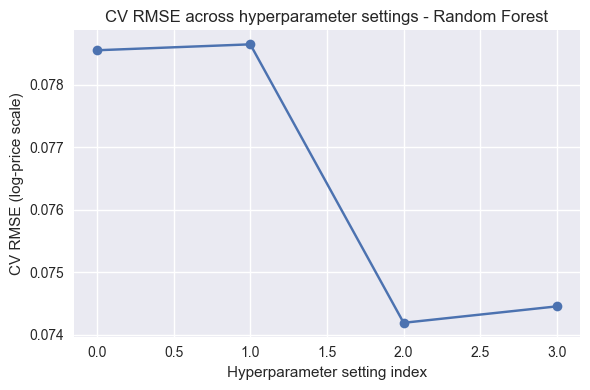

In [7]:
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_param_grid = {
    "n_estimators": [200],
    "max_depth": [10, None],
    "min_samples_split": [2, 5],
}



rf_best, rf_train_rmse, rf_test_rmse, rf_train_r2, rf_test_r2 = tune_and_evaluate(
    rf_model, rf_param_grid, "Random Forest"

)

Adaboost

In [8]:
# Baseline AdaBoost
ada_baseline = AdaBoostRegressor(random_state=42)
ada_base, ada_base_train_rmse, ada_base_test_rmse, ada_base_train_r2, ada_base_test_r2 = evaluate_baseline(
    ada_baseline, "AdaBoost"
)


Baseline AdaBoost
AdaBoost (Baseline) - Train RMSE: 69,989.91
AdaBoost (Baseline) - Test  RMSE: 71,444.36
AdaBoost (Baseline) - Train R² : 0.833
AdaBoost (Baseline) - Test  R² : 0.823
AdaBoost (Baseline) - Train RMSE: 69,989.91
AdaBoost (Baseline) - Test  RMSE: 71,444.36
AdaBoost (Baseline) - Train R² : 0.833
AdaBoost (Baseline) - Test  R² : 0.823



Tuning AdaBoost with 5-fold CV
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params for AdaBoost:
{'learning_rate': 0.1, 'loss': 'square', 'n_estimators': 200}
Best params for AdaBoost:
{'learning_rate': 0.1, 'loss': 'square', 'n_estimators': 200}
AdaBoost - Train RMSE: 73,536.44
AdaBoost - Test  RMSE: 74,651.00
AdaBoost - Train R² : 0.818
AdaBoost - Test  R² : 0.809
AdaBoost - Train RMSE: 73,536.44
AdaBoost - Test  RMSE: 74,651.00
AdaBoost - Train R² : 0.818
AdaBoost - Test  R² : 0.809


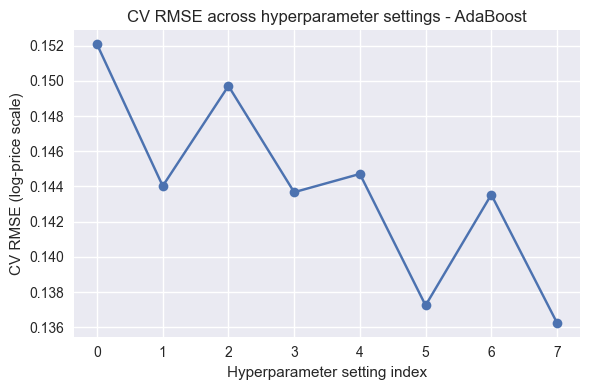

In [9]:
ada_model = AdaBoostRegressor(random_state=42)


ada_param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "loss": ["linear", "square"],
}

ada_best, ada_train_rmse, ada_test_rmse, ada_train_r2, ada_test_r2 = tune_and_evaluate(
    ada_model, ada_param_grid, "AdaBoost"

)


XGBoost

In [10]:
# Baseline XGBoost
xgb_baseline = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    eval_metric="rmse",
)
xgb_base, xgb_base_train_rmse, xgb_base_test_rmse, xgb_base_train_r2, xgb_base_test_r2 = evaluate_baseline(
    xgb_baseline, "XGBoost"
)


Baseline XGBoost
XGBoost (Baseline) - Train RMSE: 11,863.00
XGBoost (Baseline) - Test  RMSE: 38,348.22
XGBoost (Baseline) - Train R² : 0.995
XGBoost (Baseline) - Test  R² : 0.949
XGBoost (Baseline) - Train RMSE: 11,863.00
XGBoost (Baseline) - Test  RMSE: 38,348.22
XGBoost (Baseline) - Train R² : 0.995
XGBoost (Baseline) - Test  R² : 0.949



Tuning XGBoost with 5-fold CV
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params for XGBoost:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
XGBoost - Train RMSE: 14,997.32
XGBoost - Test  RMSE: 35,518.74
XGBoost - Train R² : 0.991
XGBoost - Test  R² : 0.956
Best params for XGBoost:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
XGBoost - Train RMSE: 14,997.32
XGBoost - Test  RMSE: 35,518.74
XGBoost - Train R² : 0.991
XGBoost - Test  R² : 0.956


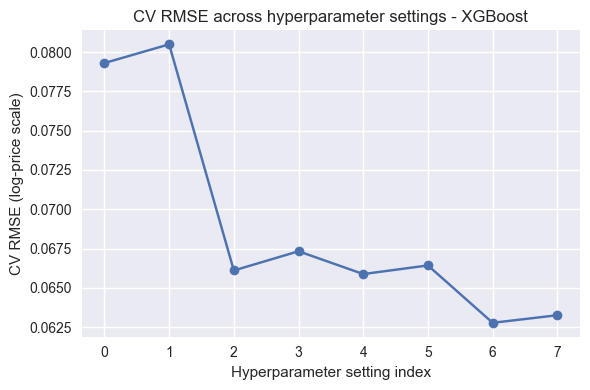

In [11]:
xgb_model = XGBRegressor(

    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    tree_method="hist",  
    eval_metric="rmse",

)


xgb_param_grid = {

    "n_estimators": [300],
    "max_depth": [3, 5],
    "learning_rate": [0.03, 0.1],
    "subsample": [0.8, 1.0],

}


xgb_best, xgb_train_rmse, xgb_test_rmse, xgb_train_r2, xgb_test_r2 = tune_and_evaluate(
    xgb_model, xgb_param_grid, "XGBoost"

)


Ensemble

In [12]:
estimators = [
    ("rf", rf_best),
    ("ada", ada_best),
    ("xgb", xgb_best),
]

stack_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    n_jobs=-1
)

stack_model.fit(X_train, y_train)

y_pred_train_stack = stack_model.predict(X_train)
y_pred_test_stack = stack_model.predict(X_test)

stack_train_rmse = rmse(y_train, y_pred_train_stack)
stack_test_rmse = rmse(y_test, y_pred_test_stack)

print("\n============ Ensemble =================")
print(f"Ensemble - Train RMSE: {stack_train_rmse:,.2f}")
print(f"Ensemble - Test  RMSE: {stack_test_rmse:,.2f}")



============ Ensemble =================
Ensemble - Train RMSE: 14,332.69
Ensemble - Test  RMSE: 35,300.25


Feature Importance Plot

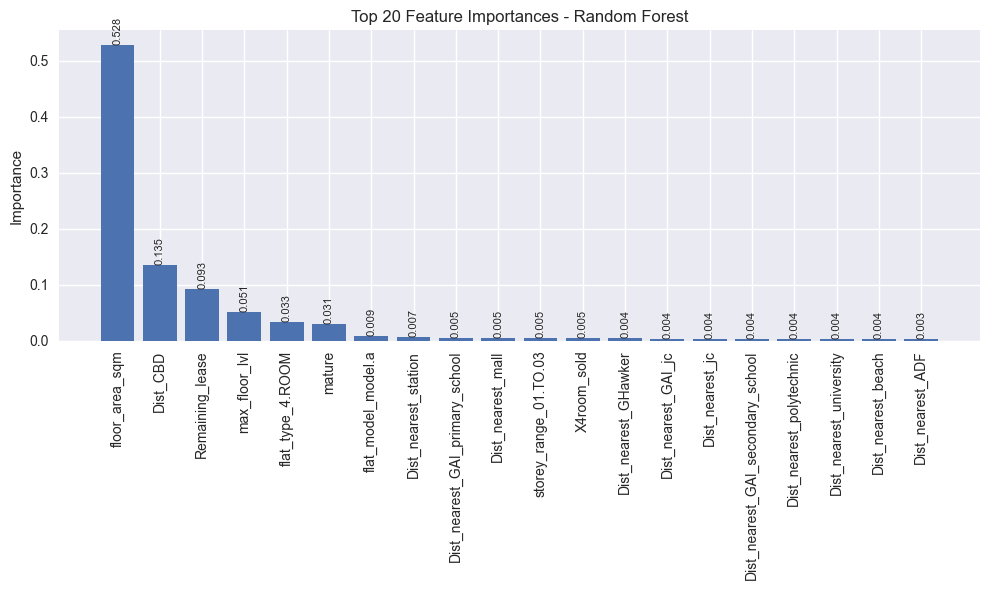

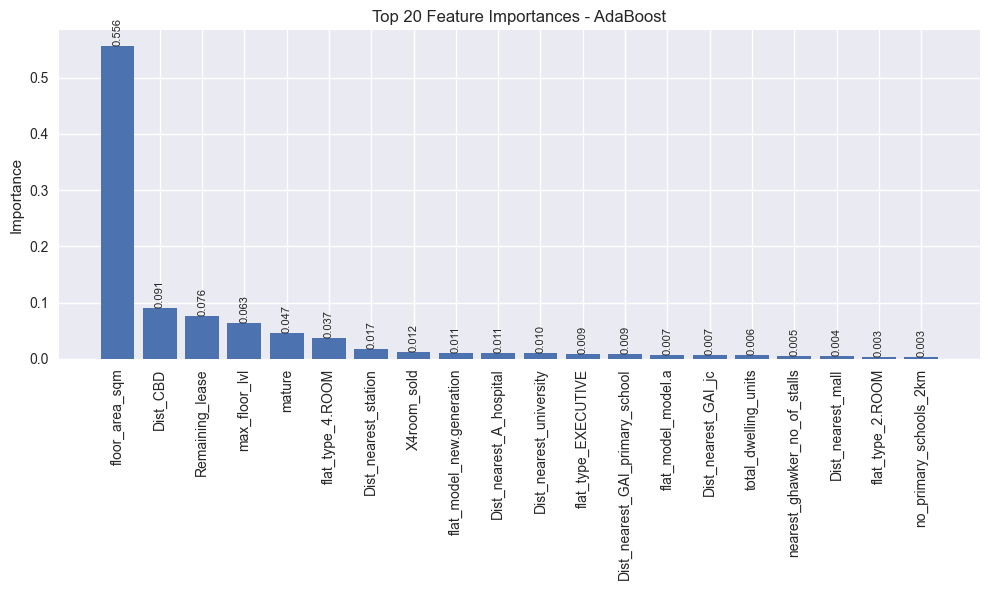

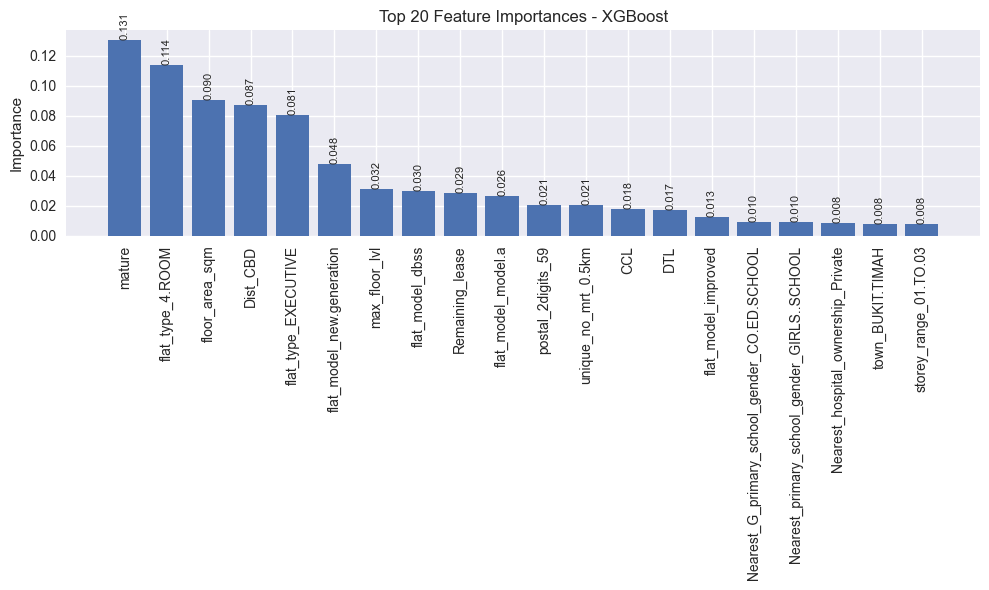

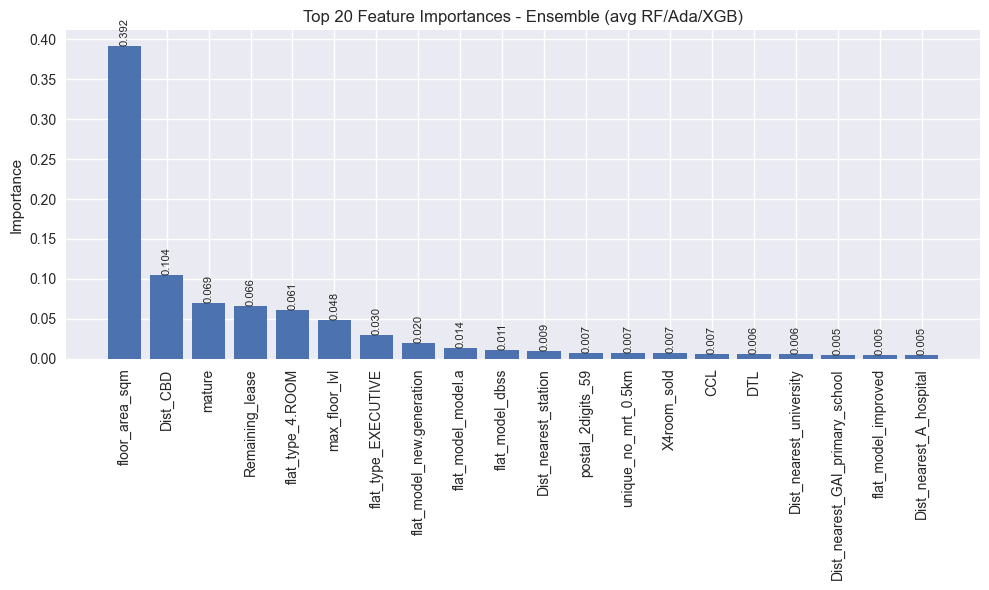

In [13]:
def plot_feature_importances(model, model_name, feature_names, top_n=20):

    """Plot top-n feature importances for tree-based models, with values on bars."""

    if not hasattr(model, "feature_importances_"):
        print(f"{model_name} has no attribute feature_importances_. Skipping.")

        return

    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(top_n), importances[indices])
    plt.xticks(range(top_n), [feature_names[i] for i in indices], rotation=90)
    plt.title(f"Top {top_n} Feature Importances - {model_name}")
    plt.ylabel("Importance")



    # Add importance values on top of each bar

    for bar, val in zip(bars, importances[indices]):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{val:.3f}",
            ha="center",
            va="bottom",
            fontsize=8,
            rotation=90,

        )



    plt.tight_layout()

    plt.show()



# Plot for RF, AdaBoost, and XGBoost

plot_feature_importances(rf_best, "Random Forest", feature_names, top_n=20)
plot_feature_importances(ada_best, "AdaBoost", feature_names, top_n=20)
plot_feature_importances(xgb_best, "XGBoost", feature_names, top_n=20)



# Approximate ensemble feature importance by averaging base model importances

if all(hasattr(m, "feature_importances_") for m in [rf_best, ada_best, xgb_best]):
    ens_importances = (
        rf_best.feature_importances_
        + ada_best.feature_importances_
        + xgb_best.feature_importances_

    ) / 3.0



    class _TmpEnsemble:

        pass


    tmp = _TmpEnsemble()
    tmp.feature_importances_ = ens_importances
    plot_feature_importances(tmp, "Ensemble (avg RF/Ada/XGB)", feature_names, top_n=20)

else:

    print("Cannot compute ensemble importances: one of the base models lacks feature_importances_.")


Top 10 fetaures for each model and their importance values

In [15]:

# Create pandas Series from feature importances
rf_series = pd.Series(rf_best.feature_importances_, index=feature_names)
ada_series = pd.Series(ada_best.feature_importances_, index=feature_names)
xgb_series = pd.Series(xgb_best.feature_importances_, index=feature_names)
ens_series = pd.Series(ens_importances, index=feature_names)

def print_top_features(series, model_name, top_n=10):
    # series: pd.Series with index = features, values = importances
    print(f"\nTop {top_n} features for {model_name}:")
    # Drop NaNs, sort desc, take top_n
    s = series.dropna().sort_values(ascending=False).head(top_n)
    for i, (feat, val) in enumerate(s.items(), start=1):
        print(f"{i}. {feat} ({val:.3f})")

print_top_features(rf_series,  "Random Forest")
print_top_features(ada_series, "AdaBoost")
print_top_features(xgb_series, "XGBoost")
print_top_features(ens_series, "Ensemble (avg RF/Ada/XGB)")


Top 10 features for Random Forest:
1. floor_area_sqm (0.528)
2. Dist_CBD (0.135)
3. Remaining_lease (0.093)
4. max_floor_lvl (0.051)
5. flat_type_4.ROOM (0.033)
6. mature (0.031)
7. flat_model_model.a (0.009)
8. Dist_nearest_station (0.007)
9. Dist_nearest_GAI_primary_school (0.005)
10. Dist_nearest_mall (0.005)

Top 10 features for AdaBoost:
1. floor_area_sqm (0.556)
2. Dist_CBD (0.091)
3. Remaining_lease (0.076)
4. max_floor_lvl (0.063)
5. mature (0.047)
6. flat_type_4.ROOM (0.037)
7. Dist_nearest_station (0.017)
8. X4room_sold (0.012)
9. flat_model_new.generation (0.011)
10. Dist_nearest_A_hospital (0.011)

Top 10 features for XGBoost:
1. mature (0.131)
2. flat_type_4.ROOM (0.114)
3. floor_area_sqm (0.090)
4. Dist_CBD (0.087)
5. flat_type_EXECUTIVE (0.081)
6. flat_model_new.generation (0.048)
7. max_floor_lvl (0.032)
8. flat_model_dbss (0.030)
9. Remaining_lease (0.029)
10. flat_model_model.a (0.026)

Top 10 features for Ensemble (avg RF/Ada/XGB):
1. floor_area_sqm (0.392)
2. Dist_

Model Summary

In [16]:
stack_train_r2 = r2_score(y_train, y_pred_train_stack)
stack_test_r2 = r2_score(y_test, y_pred_test_stack)

print("\n=========== RMSE & R² SUMMARY (Test set) ===========")
print("---- Baseline models ----")
print(f"Random Forest (Base) : RMSE = {rf_base_test_rmse:,.2f}, R² = {rf_base_test_r2:,.3f}")
print(f"AdaBoost (Base)      : RMSE = {ada_base_test_rmse:,.2f}, R² = {ada_base_test_r2:,.3f}")
print(f"XGBoost (Base)       : RMSE = {xgb_base_test_rmse:,.2f}, R² = {xgb_base_test_r2:,.3f}")

print("\n---- Tuned models ----")
print(f"Random Forest (Tuned): RMSE = {rf_test_rmse:,.2f}, R² = {rf_test_r2:,.3f}")
print(f"AdaBoost (Tuned)     : RMSE = {ada_test_rmse:,.2f}, R² = {ada_test_r2:,.3f}")
print(f"XGBoost (Tuned)      : RMSE = {xgb_test_rmse:,.2f}, R² = {xgb_test_r2:,.3f}")
print(f"Ensemble (Stacking)  : RMSE = {stack_test_rmse:,.2f}, R² = {stack_test_r2:,.3f}")



=========== RMSE & R² SUMMARY (Test set) ===========
---- Baseline models ----
Random Forest (Base) : RMSE = 41,260.94, R² = 0.943
AdaBoost (Base)      : RMSE = 71,444.36, R² = 0.823
XGBoost (Base)       : RMSE = 38,348.22, R² = 0.949

---- Tuned models ----
Random Forest (Tuned): RMSE = 41,208.61, R² = 0.943
AdaBoost (Tuned)     : RMSE = 74,651.00, R² = 0.809
XGBoost (Tuned)      : RMSE = 35,518.74, R² = 0.956
Ensemble (Stacking)  : RMSE = 35,300.25, R² = 0.957


Predicted vs Actual Plots

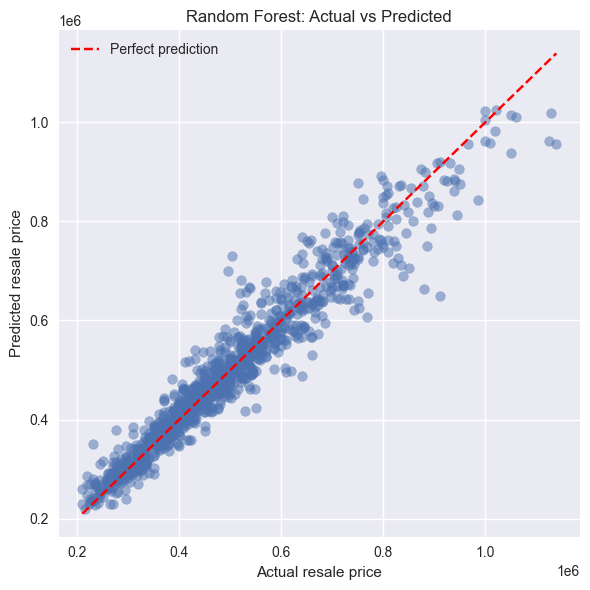

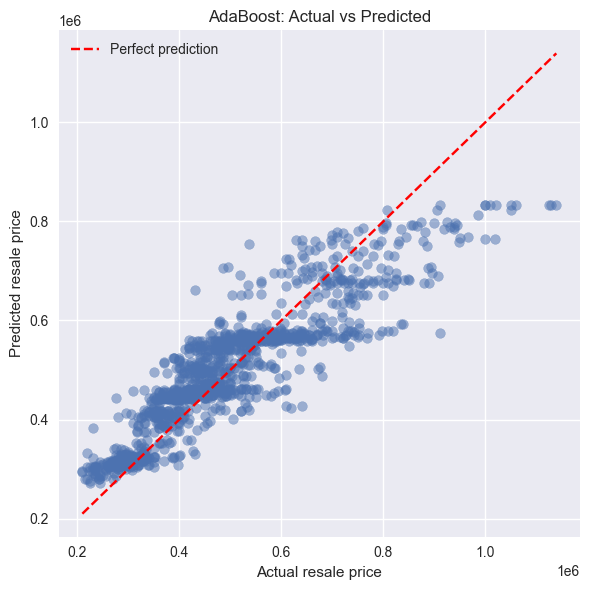

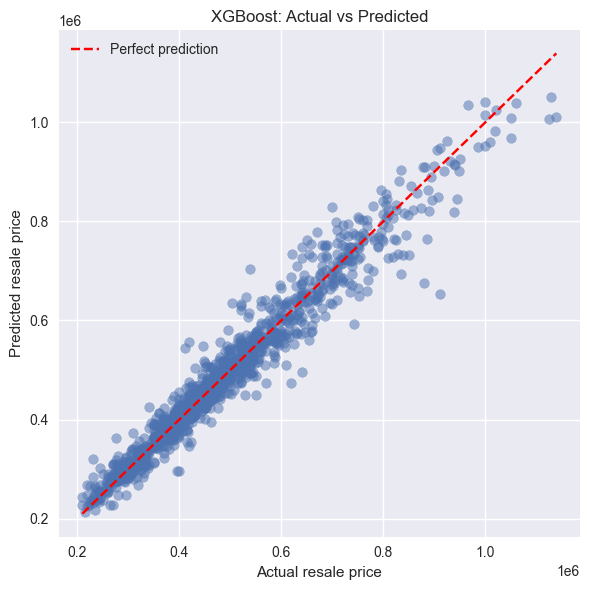

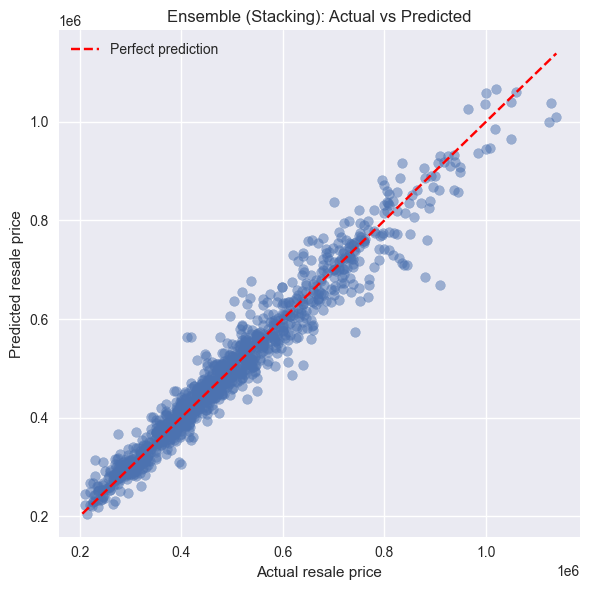

In [17]:
def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction')
    plt.xlabel('Actual resale price')
    plt.ylabel('Predicted resale price')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


y_pred_rf_log = rf_best.predict(X_test)
y_pred_ada_log = ada_best.predict(X_test)
y_pred_xgb_log = xgb_best.predict(X_test)
y_pred_stack_log = stack_model.predict(X_test)

# Convert back to original price scale
y_test_price = np.exp(y_test)
y_pred_rf = np.exp(y_pred_rf_log)
y_pred_ada = np.exp(y_pred_ada_log)
y_pred_xgb = np.exp(y_pred_xgb_log)
y_pred_stack = np.exp(y_pred_stack_log)

plot_actual_vs_predicted(y_test_price, y_pred_rf, 'Random Forest: Actual vs Predicted')
plot_actual_vs_predicted(y_test_price, y_pred_ada, 'AdaBoost: Actual vs Predicted')
plot_actual_vs_predicted(y_test_price, y_pred_xgb, 'XGBoost: Actual vs Predicted')
plot_actual_vs_predicted(y_test_price, y_pred_stack, 'Ensemble (Stacking): Actual vs Predicted')


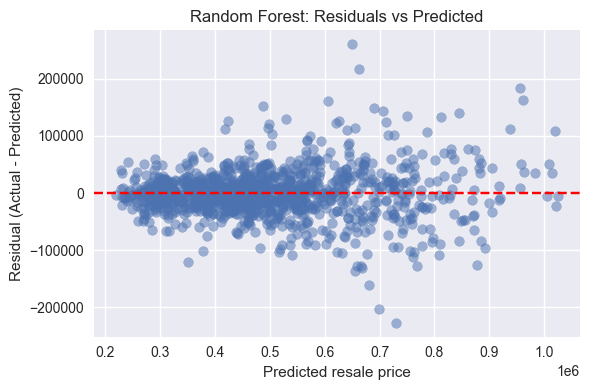

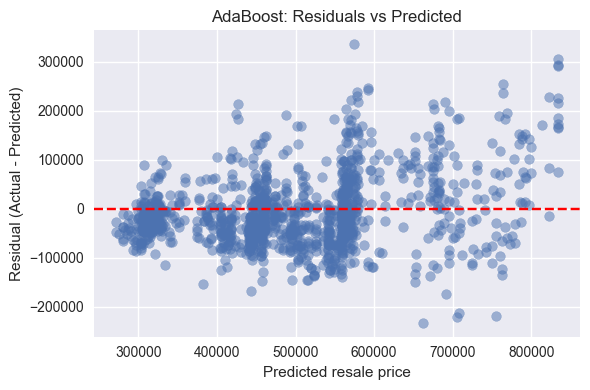

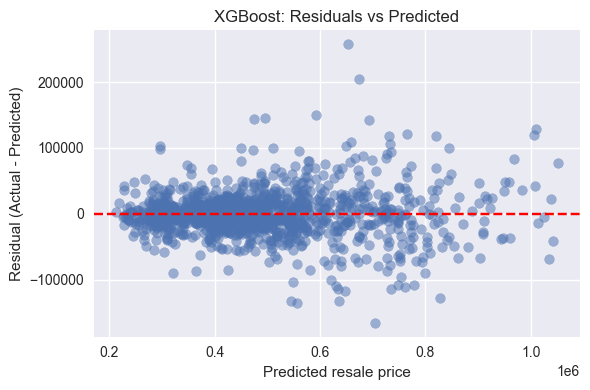

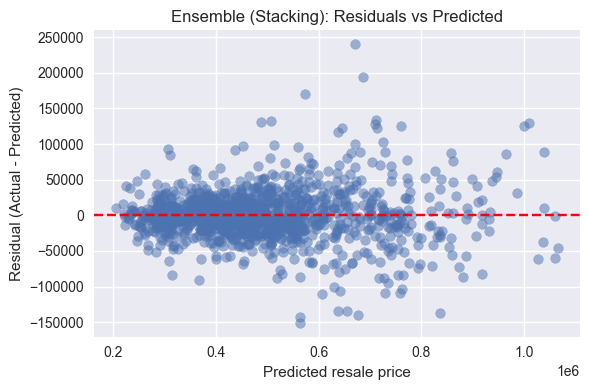

In [18]:
def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6,4))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("Predicted resale price")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Residual plots for test set in original price units
plot_residuals(y_test_price, y_pred_rf, "Random Forest: Residuals vs Predicted")
plot_residuals(y_test_price, y_pred_ada, "AdaBoost: Residuals vs Predicted")
plot_residuals(y_test_price, y_pred_xgb, "XGBoost: Residuals vs Predicted")
plot_residuals(y_test_price, y_pred_stack, "Ensemble (Stacking): Residuals vs Predicted")